In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools

# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matemáticos para aproximar una función de valor. Al utilizar este tipo de herramientas, aumentamos el riesgo de ver un comportamiento inestable y divergente durante el entrenamiento del agente. Esto se da por la presencia de tres aspectos principales, llamados 'Triada Mortal':

* Aproximación de funciones: es una forma poderosa y escalable de generalizar desde un espacio de estado mucho más grande que la memoria y los recursos computacionales (por ejemplo, aproximación de función lineal o Redes Neuronales Artificiales).

* Bootstrapping: se actualizan objetivos que son dependientes de las estimaciones existentes (por ejemplo, en los métodos de TD) en lugar de depender exclusivamente de las recompensas reales (como en aprendizaje supervisado).

* Off-Policy: Entrenamiento de un agente en base a una política diferente a la política objetivo (Por ejemplo Q-Learning).

## CartPole: Agente aleatorio
CartPole es un entorno donde un poste está unido por una unión no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanezca en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve más de 2.4 unidades desde el centro.

In [2]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementación de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Un gran problema en el uso de aproximadores para la función de valor $Q$, es que las transiciones (la experiencia del agente) están muy correlacionadas. Esto reduce la varianza general de cada transición y disminuye la capacidad de generalizacion del predictor. 
Imaginemos que tuviéramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

Para solucionar este problema, el equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en una memoria de experiencia y después de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria.

In [3]:
from agents.cart_pole_approx_vf.CartPole_SGD import SGDCartPoleSolver

agent = SGDCartPoleSolver(gym.make('CartPole-v0'), debug=True)
scores_SGD = agent.run()

[Episode 0] - Mean reward over last 100 episodes was 25.0.
[Episode 100] - Mean reward over last 100 episodes was 18.52.
[Episode 200] - Mean reward over last 100 episodes was 13.88.
[Episode 300] - Mean reward over last 100 episodes was 11.52.
[Episode 400] - Mean reward over last 100 episodes was 10.4.
[Episode 500] - Mean reward over last 100 episodes was 10.06.
[Episode 600] - Mean reward over last 100 episodes was 9.68.
[Episode 700] - Mean reward over last 100 episodes was 9.8.
[Episode 800] - Mean reward over last 100 episodes was 9.31.
[Episode 900] - Mean reward over last 100 episodes was 9.53.
[Episode 999] - Mean Mean reward over last 100 episodes was 9.35.


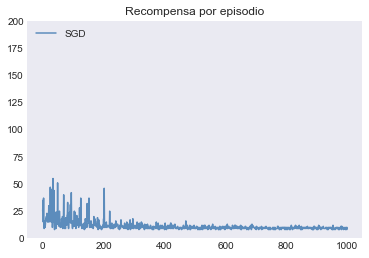

In [4]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

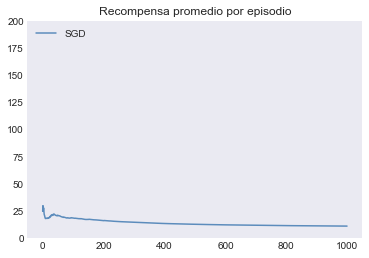

In [5]:
# se suaviza la curva de convergencia
def avg_reward(scores):
    episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
    acumulated_rewards = np.cumsum(scores)
    return [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

reward_per_episode_SGD = avg_reward(scores_SGD)

plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo que tiene estados con dos dimensiones numéricas. Para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$. Se puede elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$, pero así, no se puede tener en cuenta ninguna interacción entre estas dimensiones. Además, si tanto $s_1$ como $s_2$ son cero, entonces el valor aproximado también será cero ($x(s)=0$). Ambas limitaciones se pueden superar representando $s$ por el vector de features polinomico $x(s)=(1,s_1,s_2,s_1s_2)$. El 1 inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s1s2$, permite que se tengan en cuenta dichas interacciones. También se puede utilizar un vector de features polinomico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciones mas complejas.

En el caso del entorno CartPole, un predictor lineal que tenga como input unicamente las variables que el entorno emite no puede modelar la relacion entre la posición y velocidad del carro con respecto al angulo y velocidad del poste.

In [6]:
from agents.cart_pole_approx_vf.CartPole_SGD_Poly import SGDPolyCartPoleSolver

agent = SGDPolyCartPoleSolver(gym.make('CartPole-v0'), debug=True)
scores_SGD_Poly = agent.run()

[Episode 0] - Mean reward over last 100 episodes was 13.0.
[Episode 100] - Mean reward over last 100 episodes was 21.85.
[Episode 200] - Mean reward over last 100 episodes was 16.46.
[Episode 300] - Mean reward over last 100 episodes was 16.66.
[Episode 400] - Mean reward over last 100 episodes was 17.59.
[Episode 500] - Mean reward over last 100 episodes was 17.6.
[Episode 600] - Mean reward over last 100 episodes was 18.04.
[Episode 700] - Mean reward over last 100 episodes was 18.89.
[Episode 800] - Mean reward over last 100 episodes was 19.2.
[Episode 900] - Mean reward over last 100 episodes was 20.66.
[Episode 999] - Mean Mean reward over last 100 episodes was 20.86.


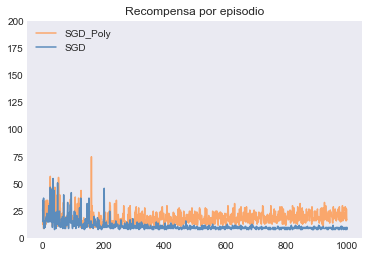

In [7]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

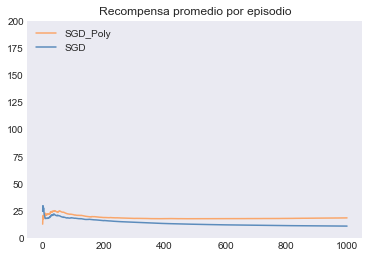

In [8]:
reward_per_episode_SGD_Poly = avg_reward(scores_SGD_Poly)

plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación actual ($w_{t}$). Donde el objetivo ($w_{t+1}$), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_{t}$ puede conducir a oscilaciones y/o divergencias en el entrenamiento del predictor.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solución para acercar el proceso de actualización de los parámetros ($w_t$) de un estimador, a un formato similar al utilizado en el aprendizaje supervisado. Esto es, se utiliza otro modelo predictivo $\tilde{q}$ como objetivo en la actualización de los pesos $w$ del estimador $\hat{q}$. Cada vez que se realizan un cierto número $C$ de actualizaciones de los pesos $w$ en el predictor $\hat{q}$, se realiza una copia de los mismos en el otro modelo $\tilde{q}$ donde se mantienen estos pesos duplicados de forma fija para las próximas $C$ actualizaciones de $w$.

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [9]:
from agents.cart_pole_approx_vf.CartPole_SGD_Poly_Dual import SGDPolyDualCartPoleSolver

agent = SGDPolyDualCartPoleSolver(gym.make('CartPole-v0'), debug=True)
scores_SGD_Poly_Dual = agent.run()

[Episode 0] - Mean reward over last 100 episodes was 10.0.
[Episode 100] - Mean reward over last 100 episodes was 19.61.
[Episode 200] - Mean reward over last 100 episodes was 13.89.
[Episode 300] - Mean reward over last 100 episodes was 11.93.
[Episode 400] - Mean reward over last 100 episodes was 10.34.
[Episode 500] - Mean reward over last 100 episodes was 10.05.
[Episode 600] - Mean reward over last 100 episodes was 9.74.
[Episode 700] - Mean reward over last 100 episodes was 9.82.
[Episode 800] - Mean reward over last 100 episodes was 9.59.
[Episode 900] - Mean reward over last 100 episodes was 9.37.
[Episode 999] - Mean Mean reward over last 100 episodes was 9.36.


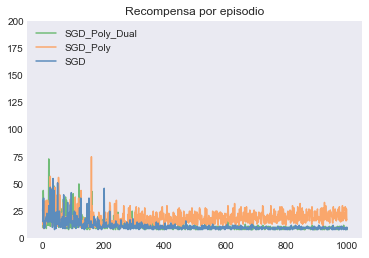

In [10]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

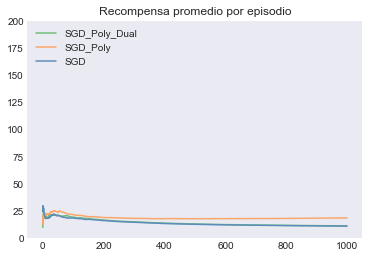

In [11]:
reward_per_episode_SGD_Poly_Dual = avg_reward(scores_SGD_Poly_Dual)
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales
Como ultima mejora, vamos a reemplazar el aproximador lineal por una red neuronal. En este caso, estamos trabajando con un entorno donde directamente el agente percibe los features que representan el estado del mismo. Por lo tanto, utilizaremos una red neuronal 'fully connected' de 3 capas con la siguiente arquitectura:

![nn_dense](images/nn_dense.png)

En este caso, como el aproximador usado es 'no lineal', no tenemos necesidad de hacer un pre-prosesamiento de los features, como en el caso del agente 'SGD_Poly' y 'SGD_Poly_Dual', para poder capturar las relaciones no lineales entre los distintos features del entorno.

### Funciones de activación:
![activation_functions](images/activation_functions.png)

In [12]:
from agents.cart_pole_approx_vf.CartPole_DQN import DQN

agent = DQN(gym.make('CartPole-v0'), debug=True)
_, scores_DQN = agent.run()

ModuleNotFoundError: No module named 'torch'

In [ ]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DQN))), np.array(scores_DQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

In [ ]:
reward_per_episode_DQN = avg_reward(scores_DQN)
plt.plot(reward_per_episode_DQN, label='DQN', c='#7e5fa4')
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))

# 1)DDQN

In [ ]:
from agents.cart_pole_approx_vf.CartPole_DDQN import DDQN

agent = DDQN(gym.make('CartPole-v0'), debug=True)
_, scores_DDQN = agent.run()

In [ ]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DDQN))), np.array(scores_DDQN), label='DDQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

# 2)Entorno: Acrobot-v1

In [ ]:
from agents.cart_pole_approx_vf.AcroBot_DDQN import DDQN

agent = DDQN(gym.make('Acrobot-v1'), debug=True)
_, scores_DDQN = agent.run()

In [ ]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DDQN))), np.array(scores_DDQN), label='DDQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()